In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch

In [5]:
import nltk

# Download the vader_lexicon
try:
    nltk.data.find('sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt')
except LookupError: # Catch the correct exception for missing resources
    print("VADER lexicon not found. Attempting download.")
    nltk.download('vader_lexicon')


# Load Sentiment Models and Tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()  # set model to evaluation mode

# Force everything on CPU
device = torch.device("cpu")
model.to(device)

# Initialize VADER
sia = SentimentIntensityAnalyzer()

VADER lexicon not found. Attempting download.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
# Load the reviews dataset
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')

In [17]:
# Text Preprocessing Function
import re # Import the re module here

def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)               # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)             # Remove mentions and hashtags
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text)       # Remove special characters
    text = text.lower().strip()                        # Lowercase & trim
    return text

# Apply preprocessing
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

In [53]:
# Batch Processing for RoBERTa and VADER
batch_size = 10
batch_texts = []
batch_ids = []

res_vader = {}
res_roberta = {}
true_sentiments = []

# Function to get RoBERTa sentiment for a batch (no autocast)
def get_roberta_sentiment_batch(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits
    scores = softmax(scores.detach().cpu().numpy(), axis=1)
    return scores

# Process first 1000 unique IDs
unique_ids = df['Id'].unique()[:1000]

for myid in unique_ids:
    text_entry = df[df['Id'] == myid]
    if not text_entry.empty:
        text = text_entry['Cleaned_Text'].values[0]  # ✅ Use cleaned text

        # VADER Sentiment
        vader_scores = sia.polarity_scores(text)
        vader_compound = vader_scores['compound']
        sentiment_category = (
            'positive' if vader_compound > 0 else
            'negative' if vader_compound < 0 else
            'neutral'
        )

        batch_texts.append(text)
        batch_ids.append(myid)
        true_sentiments.append(sentiment_category)

        # Process batch when size is met
        if len(batch_texts) == batch_size:
            batch_results = get_roberta_sentiment_batch(batch_texts)
            for i in range(len(batch_ids)):
                res_roberta[batch_ids[i]] = {
                    'roberta_neg': batch_results[i][0],
                    'roberta_neu': batch_results[i][1],
                    'roberta_pos': batch_results[i][2]
                }
            batch_texts = []
            batch_ids = []

# Process any remaining entries
if batch_texts:
    batch_results = get_roberta_sentiment_batch(batch_texts)
    for i in range(len(batch_ids)):
        res_roberta[batch_ids[i]] = {
            'roberta_neg': batch_results[i][0],
            'roberta_neu': batch_results[i][1],
            'roberta_pos': batch_results[i][2]
        }

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ---------------------------------------------------
# 1. Combine VADER and RoBERTa Results
# ---------------------------------------------------

# Encode true sentiment labels into numeric values for model training
y_true = [1 if s == 'positive' else -1 if s == 'negative' else 0 for s in true_sentiments]

# Merge VADER and RoBERTa scores per text ID
for myid in unique_ids:
    text_entry = df[df['Id'] == myid]
    if not text_entry.empty and myid in res_roberta:
        text = text_entry['Text'].values[0]
        vader_scores = sia.polarity_scores(text)  # VADER sentiment on original text
        roberta_scores = res_roberta[myid]        # RoBERTa batch sentiment already computed
        combined_scores = {**vader_scores, **roberta_scores}
        res_vader[myid] = combined_scores          # Store combined results

# ---------------------------------------------------
# 2. Prepare Final Dataset for ML Classification
# ---------------------------------------------------

data_list = []

# Build a list of combined features per ID
for myid in unique_ids:
    if myid in res_vader and myid in res_roberta:
        scores = res_vader[myid]
        data_list.append({
            'Id': myid,
            'neg': scores['neg'],
            'neu': scores['neu'],
            'pos': scores['pos'],
            'compound': scores['compound'],
            'roberta_neg': scores['roberta_neg'],
            'roberta_neu': scores['roberta_neu'],
            'roberta_pos': scores['roberta_pos']
        })

# Create DataFrame from the list
selected_df = pd.DataFrame(data_list)

# Add true sentiment labels
selected_df['sentiment'] = pd.Series(true_sentiments[:len(selected_df)], index=selected_df.index)

# ---------------------------------------------------
# 3. Feature and Target Separation
# ---------------------------------------------------

# Drop compound and sentiment columns from features
X = selected_df.drop(columns=['compound', 'sentiment'])
y = selected_df['sentiment']

# Encode target labels (positive, negative, neutral → numeric)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ---------------------------------------------------
# 4. Train/Test Split + SMOTE Oversampling
# ---------------------------------------------------

# Split into train/test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ---------------------------------------------------
# 5. Train Logistic Regression Model
# ---------------------------------------------------


# Create a pipeline: scaling + logistic regression
lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=100, max_iter=5000, solver='lbfgs')
)

# Train on balanced data
lr_pipeline.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred = lr_pipeline.predict(X_test)

# Evaluate
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.9700

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.95      0.88        22
     neutral       1.00      0.75      0.86         4
    positive       0.99      0.98      0.99       174

    accuracy                           0.97       200
   macro avg       0.93      0.89      0.91       200
weighted avg       0.97      0.97      0.97       200



In [56]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(lr_pipeline, X, y_encoded, cv=skf, scoring='accuracy')

print(f"5-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

5-Fold CV Accuracy: 0.9820 ± 0.0103


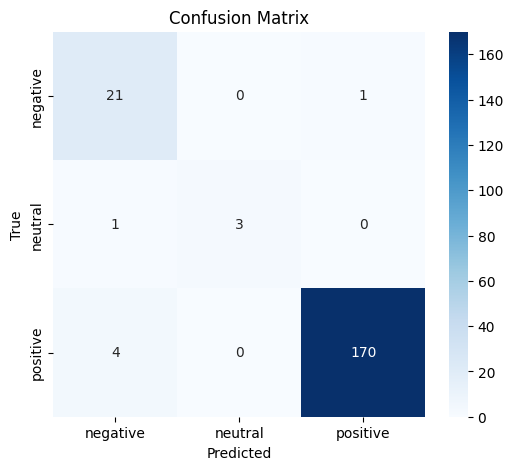

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

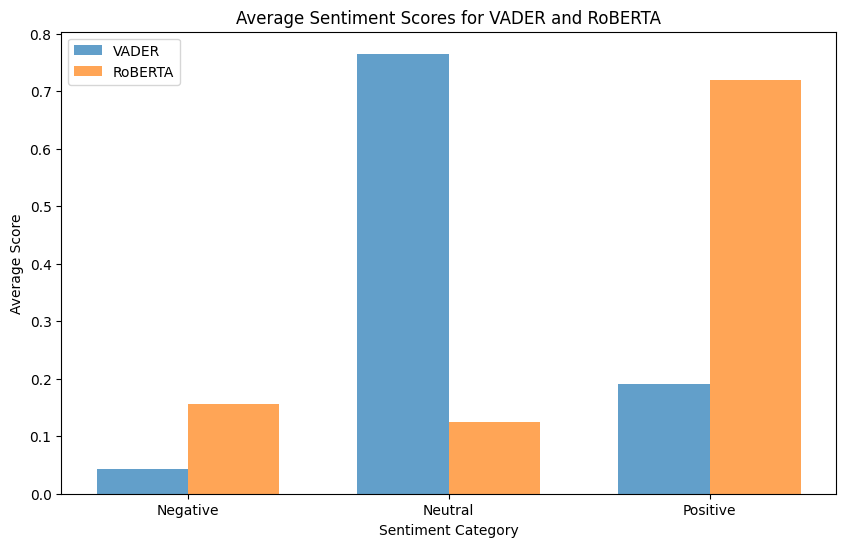

In [63]:
import matplotlib.pyplot as plt
import numpy as np

sentiment_categories = ['Negative', 'Neutral', 'Positive']
vader_avg_scores = [vader_neg_avg, vader_neu_avg, vader_pos_avg]
roberta_avg_scores = [roberta_neg_avg, roberta_neu_avg, roberta_pos_avg]

x = np.arange(len(sentiment_categories))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, vader_avg_scores, width, label='VADER', alpha=0.7)
plt.bar(x + width/2, roberta_avg_scores, width, label='RoBERTA', alpha=0.7)
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.title('Average Sentiment Scores for VADER and RoBERTA')
plt.xticks(x, sentiment_categories)
plt.legend()
plt.show()

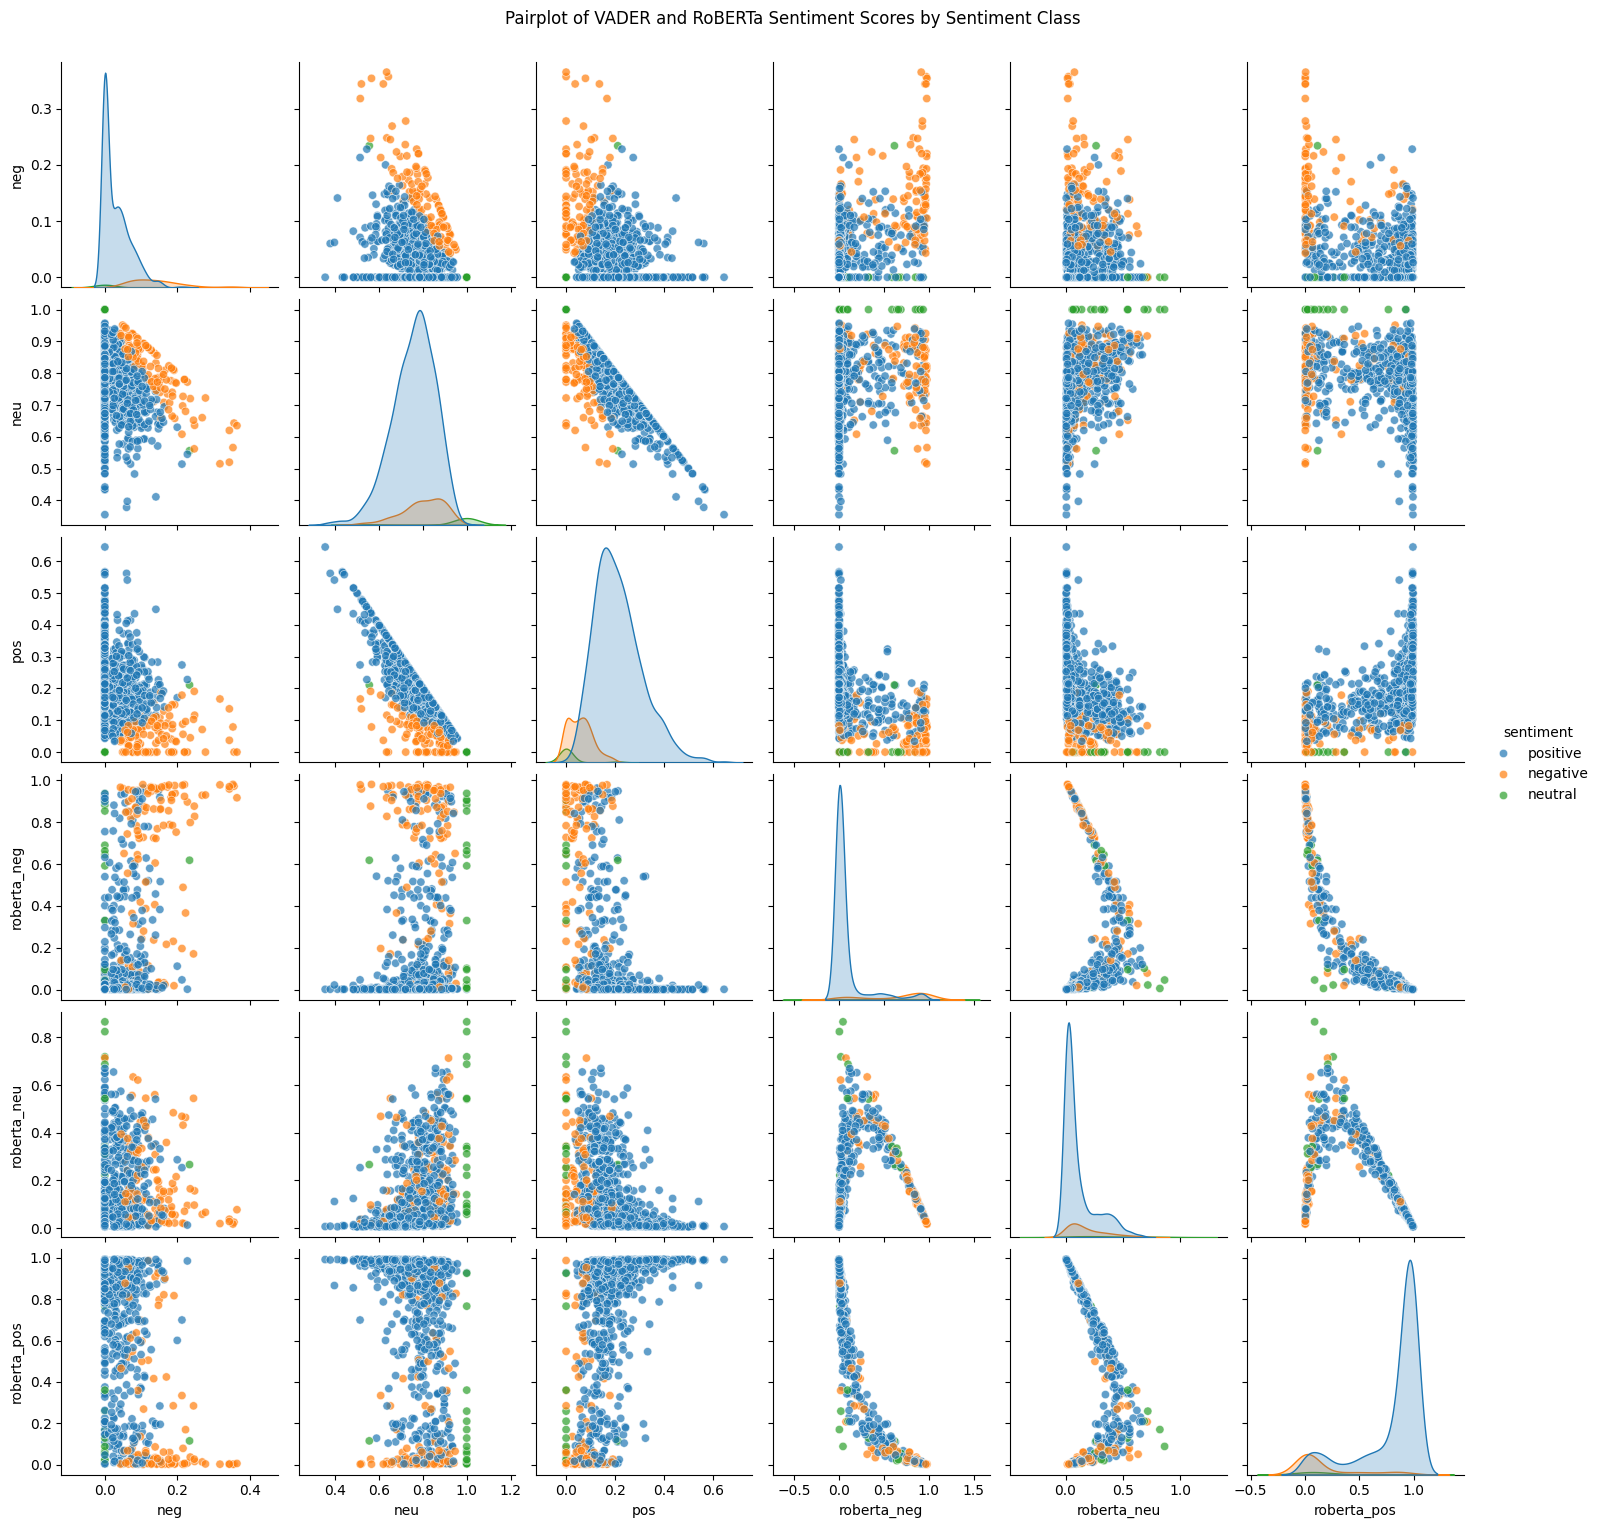

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    data=selected_df, # Changed df_final to selected_df
    vars=["neg", "neu", "pos", "roberta_neg", "roberta_neu", "roberta_pos"], # Changed column names to match selected_df
    hue="sentiment",          # Changed hue to 'sentiment' to match the column name in selected_df
    palette="tab10",
    diag_kind="kde",
    plot_kws={"alpha": 0.7}
)

plt.suptitle("Pairplot of VADER and RoBERTa Sentiment Scores by Sentiment Class", y=1.02)
plt.show()